# Plots for mixture vMF

Loads pre-computed samples and plots samples used in the paper

In [17]:
import os
import geosss as gs

import numpy as np
from csb.io import load
from arviz import autocorr
import seaborn as sns
import matplotlib.pyplot as plt
from geosss.sphere import distance
import pandas as pd
import logging
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
# set the parameters
d = 10  # dimension
K = 5  # number of mixture components
kappa = 100.0  # concentration parameter
reprod_switch = True  # generates reproducible results
plot_results = True  # plotting results
save_results = True  # saving results
n_samples = int(1e6)  # no. of samples
n_runs = 1  # sampler runs (ess only for `n_runs=10`)
burnin = int(0.1 * n_samples)  # burnin samples


# sampler methods
METHODS = ("sss-reject", "sss-shrink", "rwmh", "hmc")
ALGOS = {
    "sss-reject": "geoSSS (reject)",
    "sss-shrink": "geoSSS (shrink)",
    "rwmh": "RWMH",
    "hmc": "HMC",
}

# set filepaths and filenames
PATH = f"results/mix_vMF_d{d}_K{K}"
filename = f"mixture_vMF_d{d}_K{K}_kappa{int(kappa)}"
subdir = os.path.join(PATH, filename)

pklfile_samples = f"{subdir}/{filename}.pkl.gz"
pklfile_logprob = f"{subdir}/{filename}_logprob.pkl.gz"

# load samples and logprob
try:
    print(f"Loading file {pklfile_samples}")
    runs_samples = load(pklfile_samples, gzip=True)
except FileNotFoundError:
    raise FileNotFoundError(
        f"File {pklfile_samples} not found. Please run the sampler first."
    )

# create the subdir if it doesn't exist
os.makedirs(subdir, exist_ok=True)

# fixes modes to fix the target
mode_seed = 1234
modes = gs.sphere.sample_sphere(d - 1, K, seed=mode_seed)

# target pdf as a mixture of von Mises-Fisher distributions
vmfs = [gs.VonMisesFisher(kappa * mu) for mu in modes]
pdf = gs.MixtureModel(vmfs)


Loading file results/mix_vMF_d10_K5/mixture_vMF_d10_K5_kappa100/mixture_vMF_d10_K5_kappa100.pkl.gz


In [ ]:
# Loading the first run `ind=0` to generate plots in paper
ind = 0
samples = runs_samples if isinstance(runs_samples, dict) else runs_samples[ind]

# population of modes
modes = np.array([p.mu for p in pdf.pdfs])

# kl-divergence
KL = []
for method in METHODS:
    x = samples[method]
    m = np.argmax(x @ modes.T, axis=1)
    i, c = np.unique(m, return_counts=True)
    p = np.full(len(modes), 1e-100)
    p[i] = c
    p[i] /= p.sum()
    KL.append(p @ np.log(p / pdf.weights))


# Calculate geodesic distances
geo_dist_list = []
for method in METHODS:
    x = samples[method]
    # Compute geodesic distances between successive samples
    geo_dist = distance(x[:-1], x[1:])
    # Check for Inf or NaN values
    if not np.all(np.isfinite(geo_dist)):
        logging.warning(f"Infinite or NaN values found in geo_dist for method {method}")
        # Remove or handle these values
        geo_dist = geo_dist[np.isfinite(geo_dist)]
        logging.info(
            "average great circle distance of successive samples: "
            f"{np.mean(geo_dist):.2f} ({method})"
        )
    # Create a DataFrame for the current method
    df_method = pd.DataFrame({"geo_dist": geo_dist, "method": method})
    geo_dist_list.append(df_method)

# Combine all DataFrames into one
df_geo_dist = pd.concat(geo_dist_list, ignore_index=True)

Saving ACF-KLD-geodesic distance plot..


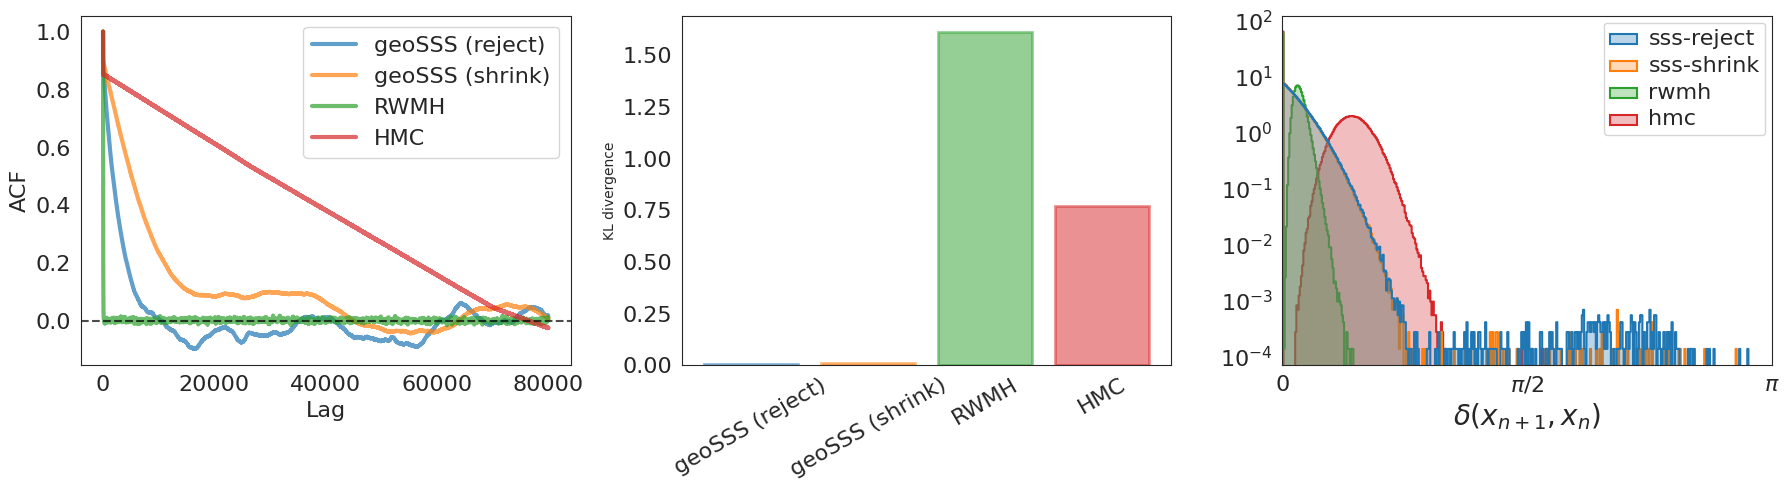

In [ ]:
save_acf_kld_dist = True
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
method_color_dict = dict(zip(METHODS, colors))
fs = 16

lag = int(8e4)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
ax = axes[0]
for method, color in zip(METHODS, colors):
    # compute autocorrelation for every method
    ac = autocorr(samples[method][:, 0])[:lag]
    ax.plot(
        ac,
        alpha=0.7,
        lw=3,
        label=ALGOS[method],
        color=color,
    )
ax.axhline(0.0, ls="--", color="k", alpha=0.7)
ax.set_xlabel(r"Lag", fontsize=fs)
ax.set_ylabel("ACF", fontsize=fs)
ax.legend(fontsize=fs, loc="upper right")
ax.tick_params(axis="both", which="major", labelsize=fs)

# KL divergence
ax2 = axes[1]
ax2.set_ylabel("KL divergence")
ax2.bar(
    list(map(ALGOS.get, METHODS)),
    KL,
    color=colors,
    alpha=0.5,
    edgecolor=colors,
    linewidth=2,
)
ax2.tick_params(axis="x", labelrotation=30)
ax2.tick_params(axis="both", labelsize=fs)

ax3 = axes[2]

# Set the style
sns.set_style("white")  # Remove the background grid

# Create the histogram plot using Seaborn
sns.histplot(
    data=df_geo_dist,
    x="geo_dist",
    hue="method",
    bins=400,
    stat="density",
    element="step",  # Use 'bars' for filled histograms
    fill=True,  # Set to True for filled histograms
    common_norm=False,  # Normalize each histogram independently
    linewidth=1.5,  # Adjust line width for better visibility
    alpha=0.3,
    ax=ax3,
    palette=method_color_dict,
    legend=True,  # Ensure legend is enabled
)

# Customize the x-axis labels and ticks
ax3.set_xlabel(r"$\delta(x_{n+1}, x_n)$", fontsize=20)
ax3.set_xticks([0, np.pi / 2, np.pi])
ax3.set_xticklabels(["0", r"$\pi/2$", r"$\pi$"], fontsize=20)
ax3.tick_params(axis="both", which="major", labelsize=fs)

# Set y-scale to logarithmic
ax3.set_yscale("log")
ax3.set_ylabel(None)  # Remove the y-axis label
ax3.set_xlim(0, np.pi)

# Customize the legend
leg = ax3.get_legend()
if leg is not None:
    leg.set_title(None)  # Remove the legend title
    for t in leg.texts:
        t.set_fontsize(fs)
    # Optionally, adjust the legend location
    leg.set_bbox_to_anchor((1, 1))
else:
    logging.warning("Legend not found in ax2.")

# Adjust layout
fig.tight_layout()

if save_acf_kld_dist:
    print("Saving ACF-KLD-geodesic distance plot..")
    fig.savefig(f"{subdir}/{filename}_acf_kld_dist.pdf", transparent=True)

Saving histogram plot with mixture marginals..


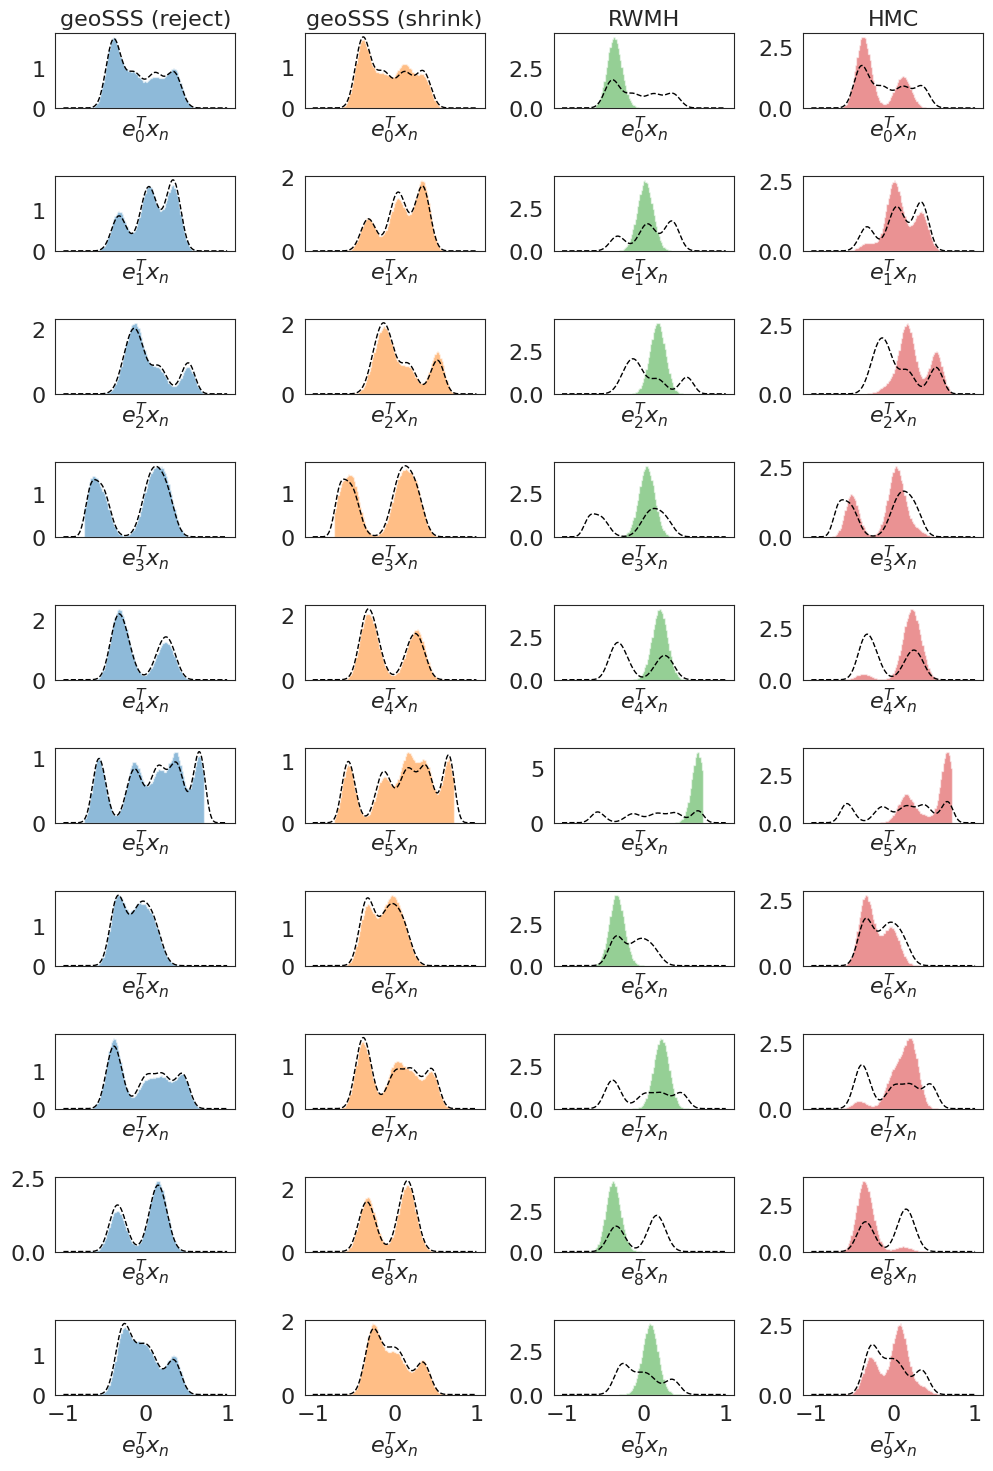

In [27]:
from geosss.distributions import MarginalVonMisesFisher, VonMisesFisher, MixtureModel


def hist_plot_mixture_marginals(
    pdf, samples, ndim, path, filename, fs=16, save_res=False
):
    """
    histogram of samples.
    """
    bins = 100
    plt.rc("font", size=fs)

    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

    # shows a standard histogram per dimension
    if ndim == 3:
        figsize = (10, 10)
    else:
        figsize = (10, 15)
    fig, rows = plt.subplots(ndim, len(METHODS), figsize=figsize, sharex=True)

    if isinstance(pdf, MixtureModel):
        mus = np.array([pdf.pdfs[i].mu for i in range(len(pdf.pdfs))])
    elif isinstance(pdf, VonMisesFisher):
        mus = pdf.mu

    # reference samples
    t = np.linspace(-1.0, 1.0, 1000)

    for d_idx, axes in enumerate(rows):
        # mixture of the marginals of von Mises-Fisher as ground truth samples
        marginalvMFs = [MarginalVonMisesFisher(d_idx, mu) for mu in mus]
        mixture_marginalvMFs = MixtureModel(marginalvMFs)
        log_p = mixture_marginalvMFs.log_prob(t)
        prob_truth = np.exp(log_p)

        # show histogram
        for ax, method in zip(axes, METHODS):
            marginals = samples[method][:, d_idx]
            bins = ax.hist(
                marginals,
                bins=bins,
                density=True,
                alpha=0.5,
                color=colors[METHODS.index(method)],
                histtype="stepfilled",
            )[1]
            ax.plot(t, prob_truth, ls="--", c="k", lw=1)
            ax.set_xlabel(rf"$e_{d_idx}^Tx_n$", fontsize=fs)

    for ax, method in zip(rows[0], METHODS):
        ax.set_title(ALGOS[method], fontsize=fs)
    fig.tight_layout()

    if save_res:
        print("Saving histogram plot with mixture marginals..")
        fig.savefig(f"{path}/{filename}_hist_marginals.pdf", transparent=True)


hist_plot_mixture_marginals(
    pdf,
    samples,
    d,
    subdir,
    filename,
    fs=fs,
    save_res=True,
)
